Download and process Antarctic shelf observations from [Schmidtko et al. Science 2014](http://science.sciencemag.org/content/346/6214/1227)

Schmidtko, Sunke, Heywood, Karen J., Thompson, Andrew F. and Aoki, Shigeru (2014) Multidecadal warming of Antarctic waters Science, 346 (6214). pp. 1227-1231.

In [1]:
import os
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

### Data download

In [10]:
# Public link of the original data provided by Sunke Schmidtko
data_link = 'http://www.geomar.de/fileadmin/personal/fb1/po/sschmidtko/Antarctic_shelf_data.txt'

# Specify path to download/access the data
data_path = ''

# if data is not yet there, download
downloaded_file = os.path.join(data_path,os.path.basename(data_link))

if not os.path.isfile(downloaded_file):
    print('Downloading Schmidtko data set')
    os.system('mkdir ' + data_path)
    os.system('wget -N ' + data_link + ' -P ' + data_path)

### Loading table and processing it to gridded dataset
Same method is used as presented in the [PISM repository](https://github.com/pism/pism-ais/blob/master/schmidtko/download_and_write_to_netcdf.py), except data is saved as a xarray Dataset before saving to netcdf

In [11]:
f = open(os.path.join(data_path, 'Antarctic_shelf_data.txt'), 'r')

In [12]:
# Read data from txt file:
lon = np.zeros(0)
lat = np.zeros(0)
depth = np.zeros(0)
c_t = np.zeros(0)
c_t_std = np.zeros(0)
abs_s = np.zeros(0)
abs_s_std = np.zeros(0)

for i,line in enumerate(f):
      if i>0:
        #print(i)
        line = line.strip()
        columns = line.split()
        lon=np.append(lon, float(columns[0]))
        lat=np.append(lat, float(columns[1]))
        depth=np.append(depth, float(columns[2]))
        c_t=np.append(c_t, float(columns[3]))
        c_t_std=np.append(c_t_std, float(columns[4]))
        abs_s=np.append(abs_s, float(columns[5]))
        abs_s_std=np.append(abs_s_std, float(columns[6]))

f.close()

In [13]:
# Creat array of lat and lon for gridded field
lat_new = np.sort(np.unique(lat)) #are sorted already
lon_new = np.sort(np.unique(lon))

In [14]:
# Move longitude vals to fit
lon_new = lon_new-360
lon_new[lon_new<-180] = 360 + lon_new[lon_new<-180]
lon_new = np.sort(lon_new)

In [15]:
# Create array for these dimensions and fill in values:
fillvalue = np.nan

theta_ocean = np.zeros((1,len(lat_new), len(lon_new))) + fillvalue
salinity_ocean = np.zeros((1,len(lat_new), len(lon_new))) + fillvalue
height   = np.zeros((1,len(lat_new), len(lon_new))) + fillvalue

In [16]:
for i in range(len(c_t)):
    # go through all temp and sal vals and fill them into the right place
    ilat = np.in1d(lat_new.ravel(), lat[i]).reshape(lat_new.shape)
    comp_lon = lon[i] - 360
    if comp_lon < -180:
        comp_lon = 360 + comp_lon
        
    ilon = np.in1d(lon_new.ravel(), comp_lon).reshape(lon_new.shape)
    theta_ocean[0,ilat,ilon] = c_t[i]
    salinity_ocean[0,ilat,ilon] = abs_s[i]
    height[0,ilat,ilon] = depth[i]

In [17]:
# Convert to xarray
ds = xr.DataArray(height[0],coords=[lat_new,lon_new],dims=['lat','lon']).to_dataset(name = 'depth')
ds.depth.attrs = {'units': 'm', 'long_name': 'Seafloor depth'}

ds['ct'] = xr.DataArray(theta_ocean[0],coords=[lat_new,lon_new],dims=['lat','lon'])
ds.ct.attrs = {'units': 'degC', 'long_name': 'Conservative temperature'}

ds['sa'] = xr.DataArray(salinity_ocean[0],coords=[lat_new,lon_new],dims=['lat','lon'])
ds.sa.attrs = {'units': 'g/kg', 'long_name': 'Absolute Salinity'}

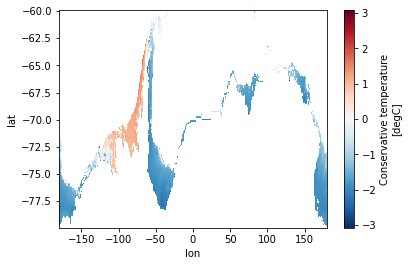

In [18]:
ds.ct.plot()

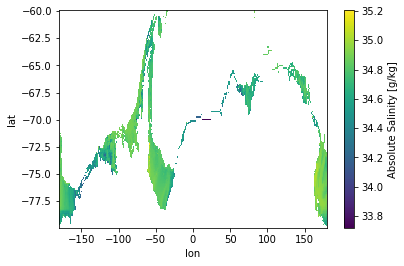

In [19]:
ds.sa.plot()

In [20]:
ds.to_netcdf('Schmidtko_Antarctic_shelf_data.nc', format='NETCDF4',
             encoding={'depth': {'dtype': 'float32','zlib': True},
                       'ct': {'dtype': 'float32','zlib': True},
                       'sa': {'dtype': 'float32','zlib': True}})

## Remapping to model grid

In [3]:
ds = xr.open_dataset('Schmidtko_Antarctic_shelf_data.nc')

In [2]:
dataurl = 'http://35.188.34.63:8080/thredds/dodsC/OM4p5/'
ds_om4 = xr.open_dataset(f'{dataurl}/ocean_monthly_z.200301-200712.nc4',
                         chunks={'time':1, 'z_l': 1}, drop_variables=['average_DT', 'average_T1', 'average_T2'])

In [8]:
grid_1x1 = xr.Dataset()
grid_1x1['lon'] = xr.DataArray(data=0.5 + np.arange(360), dims=('x'))
grid_1x1['lat'] = xr.DataArray(data=0.5 -90 + np.arange(180), dims=('y'))
grid_1x1['lon_b'] = xr.DataArray(data=np.arange(361), dims=('xp'))
grid_1x1['lat_b'] = xr.DataArray(data=-90 + np.arange(181), dims=('yp'))

In [14]:
ds.lat.values

array([-79.88, -79.75, -79.62, -79.5 , -79.38, -79.25, -79.12, -79.  ,
       -78.88, -78.75, -78.62, -78.5 , -78.38, -78.25, -78.12, -78.  ,
       -77.88, -77.75, -77.62, -77.5 , -77.38, -77.25, -77.12, -77.  ,
       -76.88, -76.75, -76.62, -76.5 , -76.38, -76.25, -76.12, -76.  ,
       -75.88, -75.75, -75.62, -75.5 , -75.38, -75.25, -75.12, -75.  ,
       -74.88, -74.75, -74.62, -74.5 , -74.38, -74.25, -74.12, -74.  ,
       -73.88, -73.75, -73.62, -73.5 , -73.38, -73.25, -73.12, -73.  ,
       -72.88, -72.75, -72.62, -72.5 , -72.38, -72.25, -72.12, -72.  ,
       -71.88, -71.75, -71.62, -71.5 , -71.38, -71.25, -71.12, -71.  ,
       -70.88, -70.75, -70.62, -70.5 , -70.38, -70.25, -70.12, -70.  ,
       -69.88, -69.75, -69.62, -69.5 , -69.38, -69.25, -69.12, -69.  ,
       -68.88, -68.75, -68.62, -68.5 , -68.38, -68.25, -68.12, -68.  ,
       -67.88, -67.75, -67.62, -67.5 , -67.38, -67.25, -67.12, -67.  ,
       -66.88, -66.75, -66.62, -66.5 , -66.38, -66.25, -66.12, -66.  ,
      

In [13]:
np.diff(ds.lat)

array([0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.12,
       0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.13,
       0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13,
       0.13, 0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.12, 0.12,
       0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.12,
       0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.13,
       0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13,
       0.13, 0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.12, 0.12,
       0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.12,
       0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.13,
       0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13,
       0.13, 0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.12, 0.12,
       0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.12,
       0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.13, 0.

In [4]:
import xesmf

In [17]:
xesmf.Regridder?

In [19]:
regrid_to_om4 = xesmf.Regridder(ds,ds_om4.rename({'geolon': 'lon', 'geolat': 'lat'}),'bilinear',periodic=True)

Create weight file: bilinear_160x1141_576x720_peri.nc


ImportError: Regrid(filename) requires PIO and does not work if ESMF has not been built with MPI support

In [6]:
ct_om4 = regrid_to_om4(ds['ct'])

<xarray.Dataset>
Dimensions:  (lat: 160, lon: 1141)
Coordinates:
  * lat      (lat) float64 -79.88 -79.75 -79.62 -79.5 ... -60.25 -60.12 -60.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Data variables:
    depth    (lat, lon) float32 ...
    ct       (lat, lon) float32 ...
    sa       (lat, lon) float32 ...

In [20]:
ds['ct']

<xarray.DataArray 'ct' (lat: 160, lon: 1141)>
[182560 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -79.88 -79.75 -79.62 -79.5 ... -60.25 -60.12 -60.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Attributes:
    units:      degC
    long_name:  Conservative temperature